In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices() 

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5897205208089780946, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 11332668621
 locality {
   bus_id: 1
 }
 incarnation: 993269867077991036
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:04:00.0"]

# setup

In [2]:
import h5py
import numpy as np
import PIL

from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers import Input, GlobalAveragePooling2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import image
from keras import optimizers
from keras import applications
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications.vgg16 import VGG16

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
import os
import numpy as np
from glob import glob
import pandas as pd

CUR_DIR = os.getcwd()
DATA_DIR = os.path.join('/scratch', 'yns207', 'data_invasive')
W_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
print(CUR_DIR, DATA_DIR)
path = DATA_DIR
test_path = os.path.join(path, 'test')
models_path = os.path.join(path, 'results')
train_path = os.path.join(path, 'train')
valid_path = os.path.join(path, 'valid')

/home/yns207/nbs/machine_learning/invasive /scratch/yns207/data_invasive


# make the model 

In [4]:
base_model = VGG16(weights='imagenet', include_top=False)

In [5]:
for layer in base_model.layers:
    layer.trainable = False
    
top_model = base_model.get_layer('block5_conv3').output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(1, activation='sigmoid')(top_model)

model = Model(inputs=base_model.input, outputs=top_model)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=0.001),
              metrics=['accuracy'])

In [6]:
batch_size = 10

img_width = 600
img_height = 450

gen = image.ImageDataGenerator()
gen_t = image.ImageDataGenerator(rescale=1., 
            featurewise_center=True,
            rotation_range=10,
            width_shift_range=.1,
            height_shift_range=.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=False,
            fill_mode="reflect")


gen.mean = np.array([111.32052594, 121.25063492, 103.65633209]).reshape(1,1,3)
gen_t.mean = np.array([111.32052594, 121.25063492, 103.65633209]).reshape(1,1,3)

tr_batches = gen.flow_from_directory(train_path, 
                                     target_size=(224,224), 
                                     class_mode='binary', 
                                     shuffle=True, 
                                     batch_size=batch_size)

tr_batches_aug = gen_t.flow_from_directory(train_path, 
                                     target_size=(224,224), 
                                     class_mode='binary', 
                                     shuffle=True, 
                                     batch_size=batch_size)

va_batches = gen.flow_from_directory(valid_path, 
                                     target_size=(224,224), 
                                     class_mode='binary', 
                                     shuffle=False, 
                                     batch_size=batch_size)

te_batches = gen.flow_from_directory(test_path, 
                                     target_size=(224,224), 
                                     class_mode='binary', 
                                     shuffle=False, 
                                     batch_size=batch_size)

Found 1836 images belonging to 2 classes.
Found 1836 images belonging to 2 classes.
Found 459 images belonging to 2 classes.
Found 1531 images belonging to 1 classes.


In [141]:
# first train 300 by 225
# next train on 600 by 450
img_width = 600  # Change image size for training here
img_height = 450 # Change image size for training here

batch_size = 5 # i achieved good and fast results with this small minibatch size for training
batch_size_val = 400 # if Tensorflow throws a memory error while validating at end of epoch, decrease validation batch size her

# set data augmentation parameters here
datagen = image.ImageDataGenerator(rescale=1., 
    featurewise_center=True,
    rotation_range=10,
    width_shift_range=.1,
    height_shift_range=.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="reflect")

# normalization neccessary for correct image input to VGG16
datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)

# no data augmentation for validation and test set
validgen = image.ImageDataGenerator(rescale=1., featurewise_center=True)
validgen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)


train_gen = datagen.flow_from_directory(
        train_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="binary",
        shuffle=True, 
        #save_to_dir="_augmented_images/", 
        #save_prefix="aug_"
        )

val_gen = validgen.flow_from_directory(
        valid_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="binary",
        shuffle=True)

test_gen = validgen.flow_from_directory(
        test_path,
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode="binary",
        shuffle=False)

train_samples = len(train_gen.filenames)
validation_samples = len(val_gen.filenames)
test_samples = len(test_gen.filenames)

Found 1836 images belonging to 2 classes.
Found 459 images belonging to 2 classes.
Found 1531 images belonging to 1 classes.


In [129]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

hist = model.fit_generator(train_gen,
                    steps_per_epoch=(train_gen.n//batch_size)+1,
                    validation_data=val_gen,
                    validation_steps=(val_gen.n//batch_size)+1,
                    epochs=10,
                    callbacks=[early_stopping])

Epoch 1/10
368/368 [==============================] - 75s - loss: 0.3204 - acc: 0.8717 - val_loss: 0.2022 - val_acc: 0.9325
Epoch 2/10
368/368 [==============================] - 73s - loss: 0.2728 - acc: 0.9022 - val_loss: 0.1808 - val_acc: 0.9281
Epoch 3/10
368/368 [==============================] - 73s - loss: 0.2476 - acc: 0.9174 - val_loss: 0.2210 - val_acc: 0.9434
Epoch 4/10
368/368 [==============================] - 73s - loss: 0.2341 - acc: 0.9185 - val_loss: 0.2022 - val_acc: 0.9281
Epoch 5/10
368/368 [==============================] - 73s - loss: 0.2332 - acc: 0.9255 - val_loss: 0.1680 - val_acc: 0.9499
Epoch 6/10
368/368 [==============================] - 73s - loss: 0.2368 - acc: 0.9255 - val_loss: 0.2094 - val_acc: 0.9499
Epoch 7/10
368/368 [==============================] - 73s - loss: 0.2223 - acc: 0.9212 - val_loss: 0.3629 - val_acc: 0.9194
Epoch 8/10
368/368 [==============================] - 73s - loss: 0.2193 - acc: 0.9321 - val_loss: 0.1381 - val_acc: 0.9564
Epoch 9/

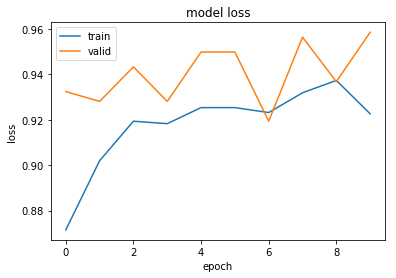

In [130]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()